In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, auc, precision_score, recall_score

## Loading the Dataset
 The dataset is loaded and unnecessary columns, such as `id`, are removed and `age` is converted into yeears.

In [2]:
df = pd.read_csv("cardio_train_data/cardio_train.csv",sep=";")
df.drop(["id"],axis=1,inplace=True)     #dropping the "id" column
df["age"] = df["age"]/365   #converting age into years
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
5,60.038356,1,151,67.0,120,80,2,2,0,0,0,0
6,60.583562,1,157,93.0,130,80,3,1,0,0,1,0
7,61.873973,2,178,95.0,130,90,3,3,0,0,1,1
8,48.405479,1,158,71.0,110,70,1,1,0,0,1,0
9,54.339726,1,164,68.0,110,60,1,1,0,0,0,0


### Checking the dataset for null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.4 MB


In [4]:
#checking for null values
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

### Splitting the features into numerical and categorical features

In [5]:
#number of unique values each feature has
df.nunique()

age            8076
gender            2
height          109
weight          287
ap_hi           153
ap_lo           157
cholesterol       3
gluc              3
smoke             2
alco              2
active            2
cardio            2
dtype: int64

In [6]:
categorical_columns = ["gender","cholesterol","gluc","smoke","alco","active","cardio"]
numerical_columns = ["age","height","weight","ap_hi","ap_lo"]

## Feature Selection
### Pre-processing numerical features

In [7]:
df[numerical_columns].describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339358,164.359229,74.205690,128.817286,96.630414
std,6.759594,8.210126,14.395757,154.011419,188.472530
min,29.583562,55.000000,10.000000,-150.000000,-70.000000
25%,48.394521,159.000000,65.000000,120.000000,80.000000
50%,53.980822,165.000000,72.000000,120.000000,80.000000
75%,58.430137,170.000000,82.000000,140.000000,90.000000
max,64.967123,250.000000,200.000000,16020.000000,11000.000000


#### Creating boxplot for `ap_lo` and `ap_hi` and filtering unrealistic values

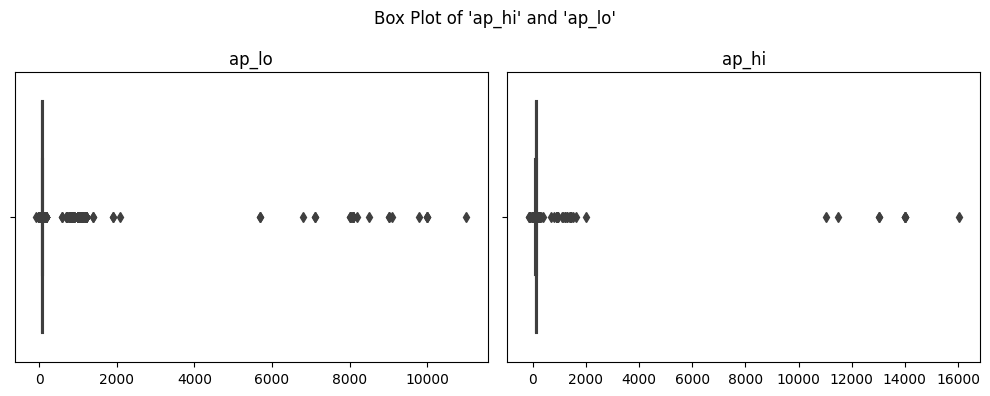

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

sns.boxplot(df, x= "ap_lo", ax = ax[0])
sns.boxplot(df, x= "ap_hi", ax = ax[1])
ax[0].set_title("ap_lo")
ax[0].set_xlabel(None)
ax[1].set_title("ap_hi")
ax[1].set_xlabel(None)
fig.suptitle("Box Plot of 'ap_hi' and 'ap_lo'")
plt.tight_layout()

**Observation**: The blood pressure values should fall within a physiologically realistic range. Values outside this range will be filtered. We choose the thershold of 370/360 mm Hg as given [here](<https://pubmed.ncbi.nlm.nih.gov/7741618/#:~:text=The%20highest%20pressure%20recorded%20in,005).&text=BP%20was%20recorded%20in%2010,maximal%20lifting%20with%20slow%20exhalation.>).

In [9]:
#filetering unrealistic blood pressure values
df = df[(df["ap_hi"] <= 370) & (df["ap_hi"] >= 0)]
df = df[(df["ap_lo"] <= 360) & (df["ap_lo"] >= 0)].reset_index(drop=True) 

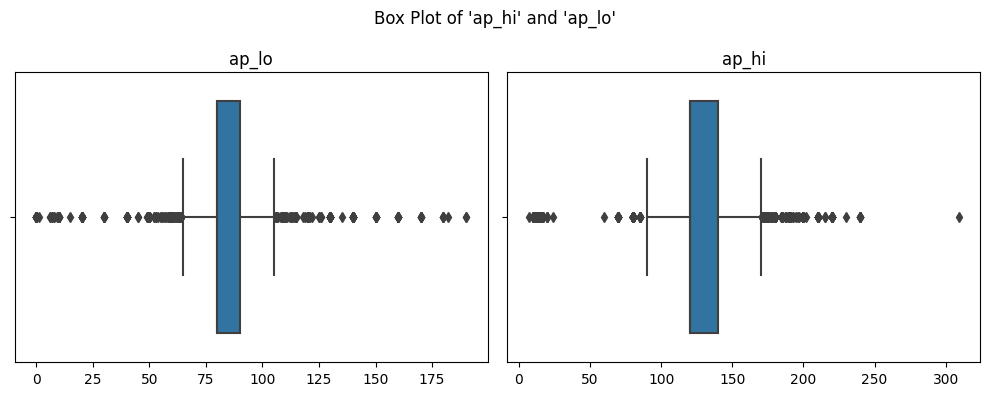

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

sns.boxplot(df, x= "ap_lo", ax = ax[0])
sns.boxplot(df, x= "ap_hi", ax = ax[1])
ax[0].set_title("ap_lo")
ax[0].set_xlabel(None)
ax[1].set_title("ap_hi")
ax[1].set_xlabel(None)
fig.suptitle("Box Plot of 'ap_hi' and 'ap_lo'")
plt.tight_layout()

#### Creating histogram plot with `cardio` as hue

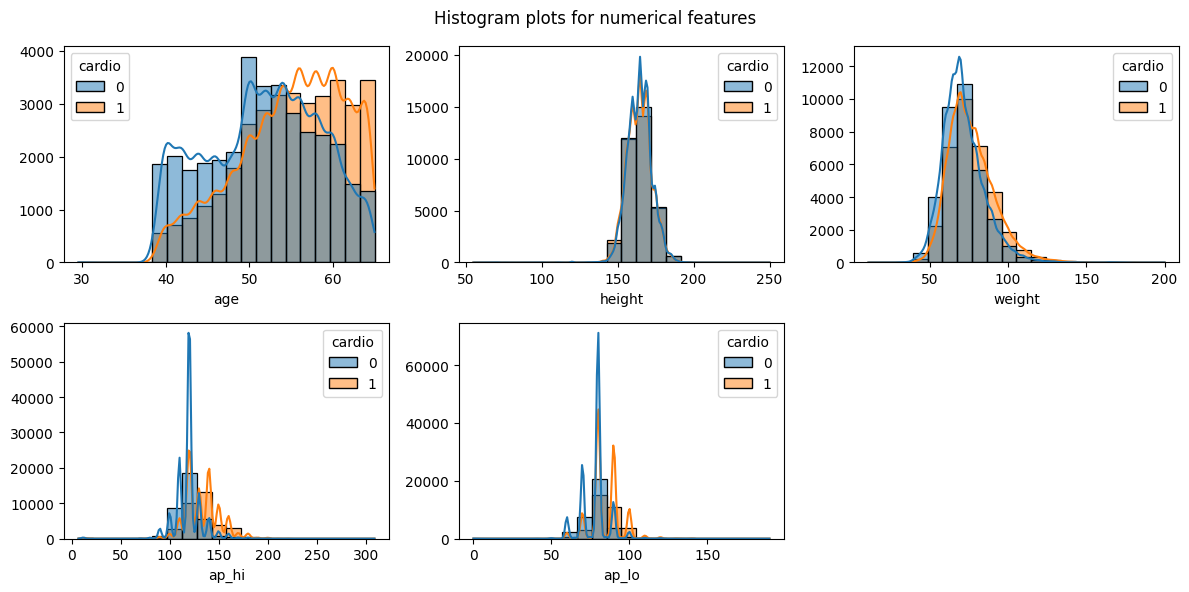

In [11]:
fig, ax = plt.subplots(nrows= int(np.ceil(len(numerical_columns)/3)), ncols=3, figsize = (12,6))
for k,col in enumerate(numerical_columns):
    r = int(k//3)
    c = int(k%3)
    sns.histplot(data = df, x = col, bins= 20, hue = "cardio", ax=ax[r,c],kde= True)
    ax[r,c].set_ylabel(None)
k += 1
r = int(k//3)
c = int(k%3)
fig.delaxes(ax=ax[r,c])
plt.suptitle("Histogram plots for numerical features")
plt.tight_layout()

#### Creating boxplot with `cardio` as hue

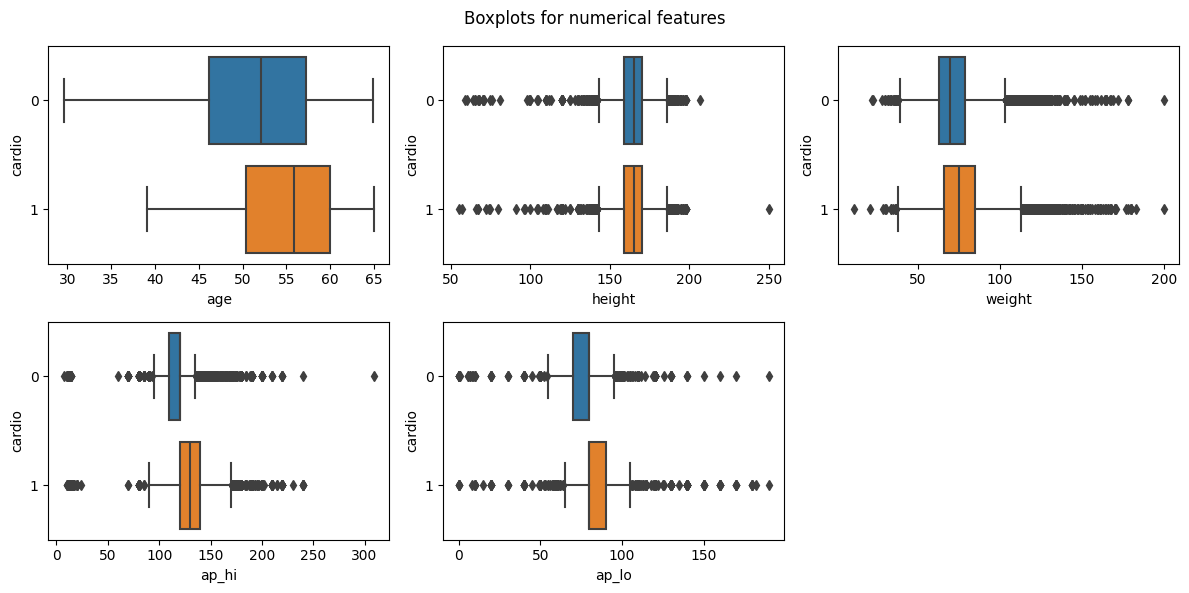

In [12]:
df["cardio"] = df["cardio"].astype(str)
fig, ax = plt.subplots(nrows= int(np.ceil(len(numerical_columns)/3)), ncols=3, figsize = (12,6))
for k,col in enumerate(numerical_columns):
    r = int(k//3)
    c = int(k%3)
    sns.boxplot(data = df, x = col, y = "cardio", ax=ax[r,c])
k += 1
r = int(k//3)
c = int(k%3)
fig.delaxes(ax=ax[r,c])
plt.suptitle("Boxplots for numerical features")
plt.tight_layout()

#### Scaling numerical features

The numerical features is scaled using standard scaler as the data is normally distributed which is evident from the histogram plot.

In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit(df[numerical_columns])
scaled_numerical_data = scaler.transform(df[numerical_columns])
df[numerical_columns] = scaled_numerical_data
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0,0


#### Checking correlation between numerical features using correlation matrix

In [14]:
corr_matrix = df[numerical_columns].corr()
corr_matrix

,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.080724,0.055154,0.197734,0.150938
height,-0.080724,1.000000,0.291529,0.017576,0.035898
weight,0.055154,0.291529,1.000000,0.254697,0.245399
ap_hi,0.197734,0.017576,0.254697,1.000000,0.644223
ap_lo,0.150938,0.035898,0.245399,0.644223,1.000000


Thus, no two numerical features are related.

### Pre-processing categorical features ###

#### Looking at categorical features

In [15]:
df[categorical_columns].head(10)

,gender,cholesterol,gluc,smoke,alco,active,cardio
0,2,1,1,0,0,1,0
1,1,3,1,0,0,1,1
2,1,3,1,0,0,0,1
3,2,1,1,0,0,1,1
4,1,1,1,0,0,0,0
5,1,2,2,0,0,0,0
6,1,3,1,0,0,1,0
7,2,3,3,0,0,1,1
8,1,1,1,0,0,1,0
9,1,1,1,0,0,0,0


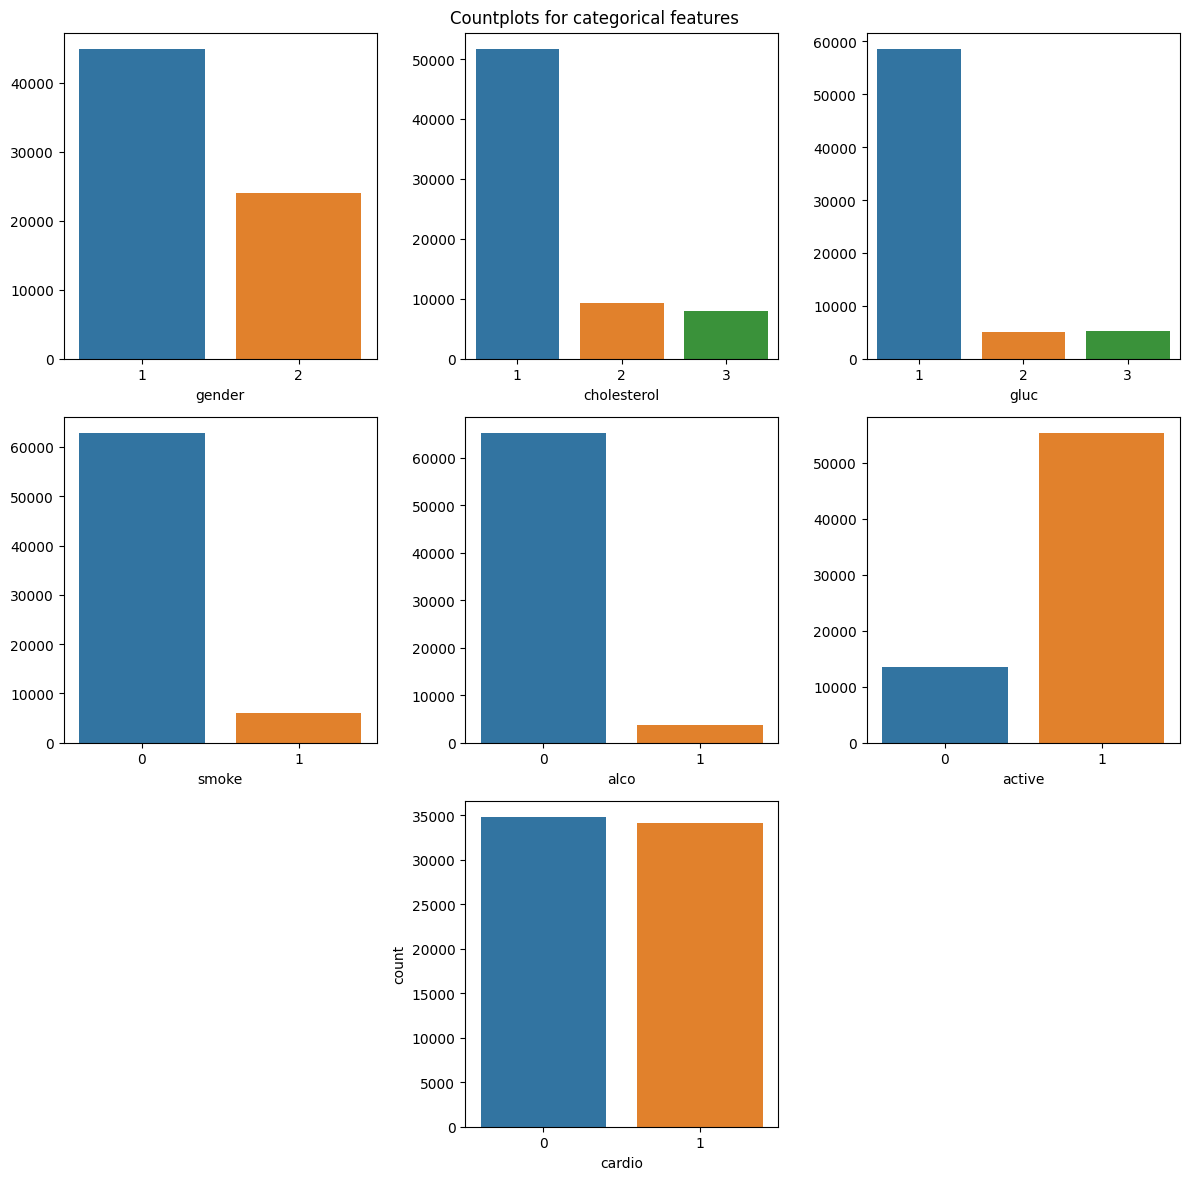

In [16]:
#countplot for each categorical features
fig, ax = plt.subplots(nrows= int(np.ceil(len(categorical_columns)/3)), ncols=3, figsize = (12,12))
for k,col in enumerate(categorical_columns[:-1]):
    r = int(k//3)
    c = int(k%3)
    sns.countplot(data = df, x = col, ax=ax[r,c])
    ax[r,c].set_ylabel(None)
sns.countplot(data=df, x = "cardio", ax=ax[2,1])
fig.delaxes(ax=ax[2,0])
fig.delaxes(ax=ax[2,2])
plt.suptitle("Countplots for categorical features")
plt.tight_layout()

#### Creating countplot with `cardio` as hue

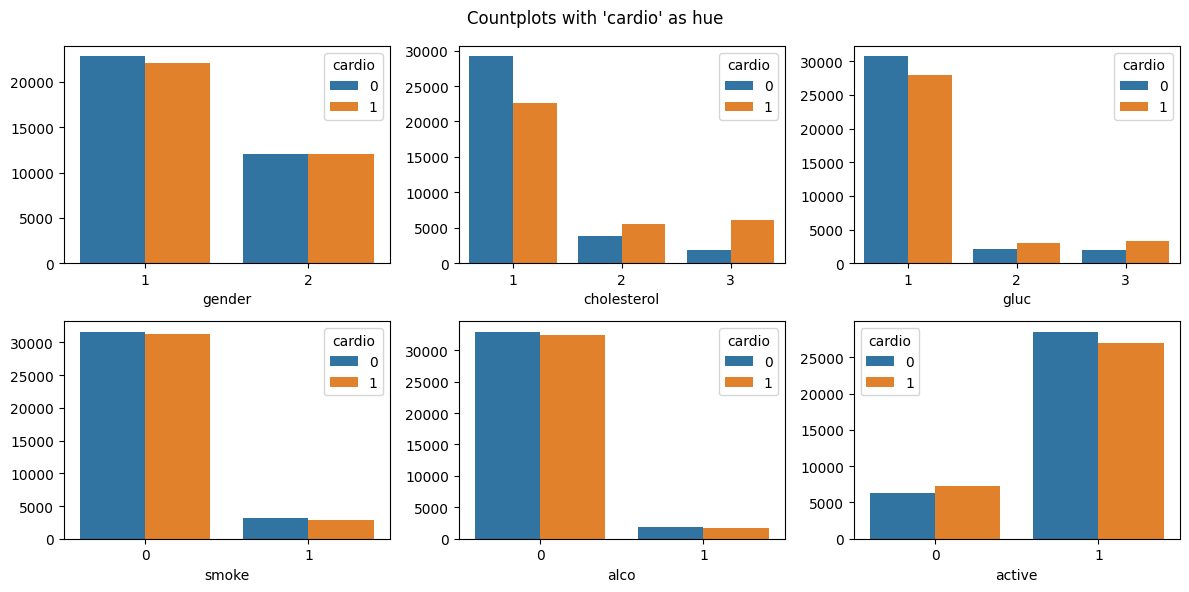

In [17]:
df["cardio"] = df["cardio"].astype(str)
fig, ax = plt.subplots(nrows= int(np.ceil(len(categorical_columns[:-1])/3)), ncols=3, figsize = (12,6))
for k,col in enumerate(categorical_columns[:-1]):
    r = int(k//3)
    c = int(k%3)
    sns.countplot(data = df, x = col, hue = "cardio", ax=ax[r,c])
    ax[r,c].set_ylabel(None)
plt.suptitle("Countplots with 'cardio' as hue")
plt.tight_layout()

#### Checking relation between categorical features

In [18]:
#this function calculates chi^2 and p-value from the contigency table between two features
def calc_chi2(df, feature1, feature2):
    contingency_table = pd.crosstab(df[feature1],df[feature2],margins= True)
    chi2_value, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2_value, p_value

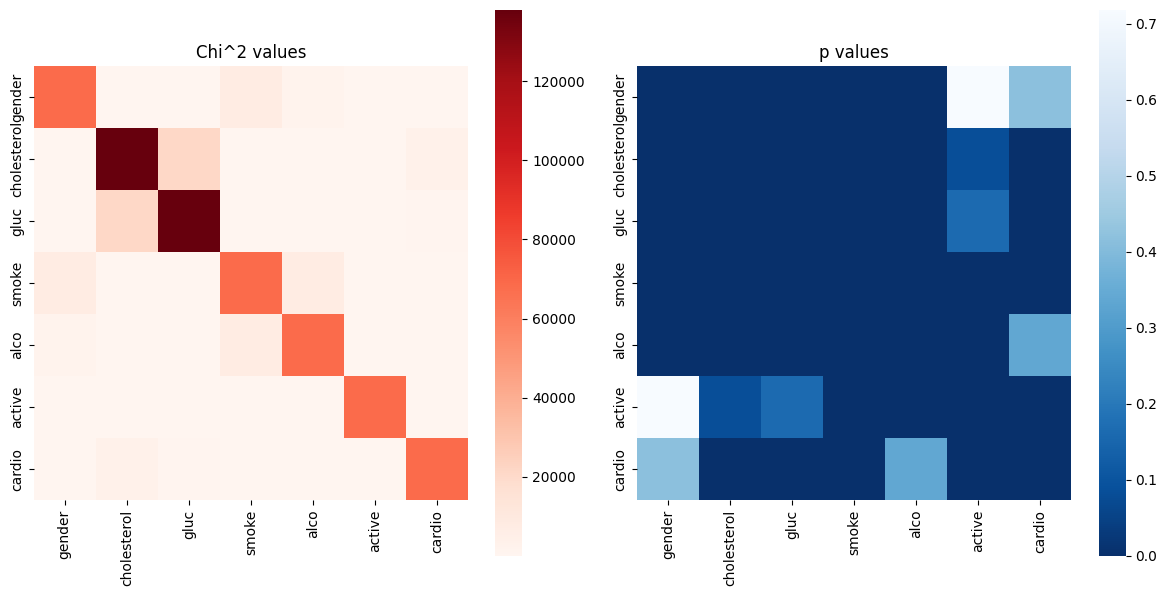

In [19]:
chi2_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))    #matrix for storing chi^2 values between all the features
p_matrix = np.zeros_like(chi2_matrix)   #matrix for storing p-values between all the features

#using calc_chi2 to calculate chi^2-values and p-values between each categorical variables
for i,col1 in enumerate(categorical_columns):
    for j,col2 in enumerate(categorical_columns):
        chi2_value, p_value = calc_chi2(df,col1,col2)
        chi2_matrix[i,j] = chi2_value
        p_matrix[i,j] = p_value

chi2_matrix = pd.DataFrame(data=chi2_matrix, index=categorical_columns, columns=categorical_columns) 
p_matrix = pd.DataFrame(data=p_matrix, index=categorical_columns, columns=categorical_columns)

#heatmap for chi^2-values and p-values
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.heatmap(chi2_matrix, ax = ax[0], cmap="Reds")
sns.heatmap(p_matrix, ax=ax[1], cmap="Blues_r")
ax[0].set_aspect("equal")
ax[0].set_title("Chi^2 values")
ax[1].set_aspect("equal")
ax[1].set_title("p values")
plt.tight_layout()

In [20]:
p_matrix

,gender,cholesterol,gluc,smoke,alco,active,cardio
gender,0.000000e+00,3.618490e-18,2.645815e-05,0.000000e+00,0.000000e+00,7.181048e-01,4.167186e-01
cholesterol,3.618490e-18,0.000000e+00,0.000000e+00,2.583436e-07,9.822637e-28,8.291622e-02,0.000000e+00
gluc,2.645815e-05,0.000000e+00,0.000000e+00,1.262401e-04,5.049004e-12,1.607945e-01,6.117519e-123
smoke,0.000000e+00,2.583436e-07,1.262401e-04,0.000000e+00,0.000000e+00,2.961248e-09,1.040722e-03
alco,0.000000e+00,9.822637e-28,5.049004e-12,0.000000e+00,0.000000e+00,5.690918e-09,3.377477e-01
active,7.181048e-01,8.291622e-02,1.607945e-01,2.961248e-09,5.690918e-09,0.000000e+00,7.485367e-20
cardio,4.167186e-01,0.000000e+00,6.117519e-123,1.040722e-03,3.377477e-01,7.485367e-20,0.000000e+00


The p_value of the feature `alco` as compared with `cardio` is greater than 0.05, which implies that `alco` is independent of the target variable `cardio`. Also, The p_value of the feature `alco` as compared with other categorical features is less than 0.05, which implies that `alco` is dependent on all other categorical features. Thus, we can safely discard `alco` from out ddataset.

In [21]:
df.drop(["alco"], axis = 1, inplace = True) #dropping the "alco" feature

## Splitting the dataset into trainning and test

In [22]:
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0


In [23]:
X = df.drop(["cardio"],axis=1)
y = df["cardio"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

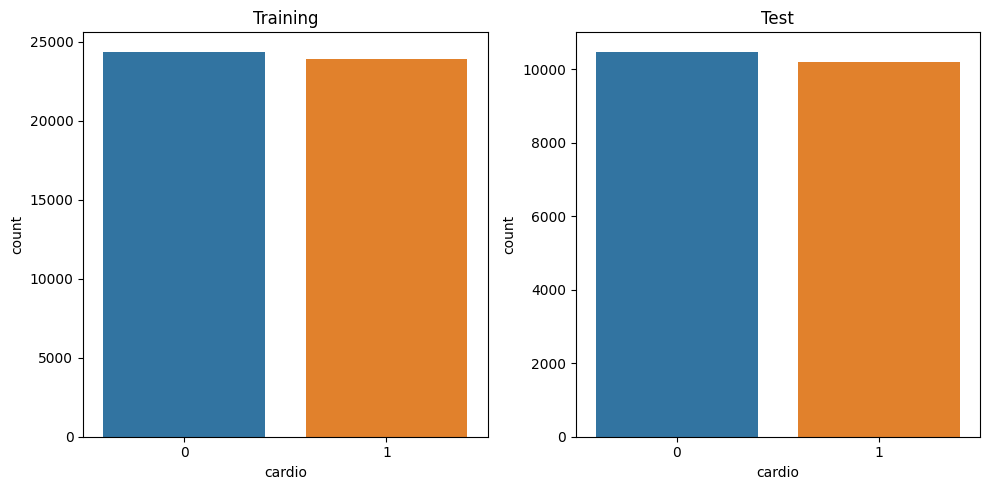

In [24]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.countplot(data=df, x = y_train, ax = ax[0])
ax[0].set_title("Training")
sns.countplot(data=df, x = y_test, ax = ax[1])
ax[1].set_title("Test")
plt.tight_layout()

The training and test have similar distribution of target variable `cardio`.

## Model Selection
### Defining parameter grid and performing Cross Validation

In [25]:
models = {
    "LR" : {
        "model": LogisticRegression(penalty="l2"),
        "params_grid": {
            "C" : [0.01,0.1,1,10]
        }
    },

    "KNN" : {
        "model": KNeighborsClassifier(),
        "params_grid": {
            "n_neighbors" : [50,100,200,500]
        }
    },

    "Linear_SVC" : {
        "model": LinearSVC(max_iter= 10000),
        "params_grid":{
            "C" : [0.001,0.01,0.1,1]
        }
    },

    "SVM": {
        "model": SVC(gamma="auto"),
        "params_grid": {
            "kernel" : ["sigmoid", "rbf"],
            "C": [0.01, 0.1,1,10]
        }
    },

    "Decision_Tree" : {
        "model": DecisionTreeClassifier(),
        "params_grid": {
            "criterion": ["gini", "entropy"],
            "max_depth": [5,10,20]
        }
    },

    "Bagging":{
        "model": BaggingClassifier(),
        "params_grid": {
            "n_estimators" : [10, 50, 100,500],
            "max_samples": [0.5, 0.75, 1]
        }
    },

    "Random_Forest": {
        "model" : RandomForestClassifier(),
        "params_grid" : {
            "n_estimators": [100,500,1000],
            "criterion" : ["gini", "entropy"]
        }

    },

    "Gradient_Boosting": {
        "model": GradientBoostingClassifier(),
        "params_grid": {
            "learning_rate" : [0.05, 0.1, 0.5, 1],
            "n_estimators": [10,50,100]
        }

    },

    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params_grid": {
            "n_estimators": [10,50,100],
        }
    }
}

In [26]:
scores = []

#performing 5-fold cross validation and tuning the classification models
for model_name, param in models.items():
    classifier = GridSearchCV(estimator= param["model"], param_grid= param["params_grid"], cv= ShuffleSplit(n_splits=5, test_size=0.3), scoring= "recall", n_jobs=-1)
    classifier.fit(X_train, y_train)
    scores.append({
        "model" : model_name,
        "best_params" : classifier.best_params_,
        "best_score" : classifier.best_score_
    })

scores = pd.DataFrame(scores, columns= ["model", "best_params", "best_score"]).sort_values(by = "best_score").sort_values(by = "best_score", ascending= False)
scores

,model,best_params,best_score
5,Bagging,"{'max_samples': 1, 'n_estimators': 10}",0.800000
6,Random_Forest,"{'criterion': 'gini', 'n_estimators': 500}",0.704097
7,Gradient_Boosting,"{'learning_rate': 1, 'n_estimators': 10}",0.702002
3,SVM,"{'C': 1, 'kernel': 'rbf'}",0.678160
4,Decision_Tree,"{'criterion': 'entropy', 'max_depth': 10}",0.676304
0,LR,{'C': 10},0.673347
1,KNN,{'n_neighbors': 50},0.669551
2,Linear_SVC,{'C': 0.001},0.662685
8,AdaBoost,{'n_estimators': 50},0.659039


Parameter grids are created for various classification models and the best three model with the best parameters are selected for further prediction.

### Random Forest
#### Training and predicting the classifier

In [27]:
Random_Forest = RandomForestClassifier(n_estimators=1000, criterion= "gini")
Random_Forest = Random_Forest.fit(X_train,y_train)
y_pred = Random_Forest.predict(X_test)

#### Calculating the accuracy scores using confusion matrix

In [28]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7574,2911
Actual 1,3094,7121


In [29]:
precision = precision_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"{classification_report(y_test, y_pred)}")
print(f"Precision: {precision:.2f}%")
print(f"F1_score: {f1:.2f}%")

              precision    recall  f1-score   support

           0       0.71      0.72      0.72     10485
           1       0.71      0.70      0.70     10215

    accuracy                           0.71     20700
   macro avg       0.71      0.71      0.71     20700
weighted avg       0.71      0.71      0.71     20700

Precision: 70.98%
F1_score: 70.34%


#### Plotting ROC curve and Precision-Recall curve

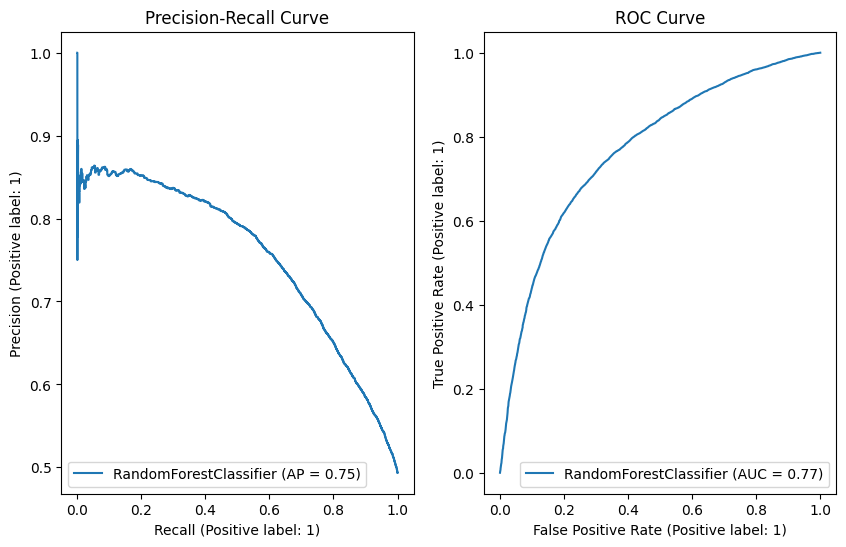

In [30]:
recall = recall_score(y_test, y_pred)
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(Random_Forest, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(Random_Forest, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Bagging
#### Training and predicting the classifier

In [31]:
BC = BaggingClassifier(n_estimators=500, max_samples= 0.75)
BC = BC.fit(X_train,y_train)
y_pred = BC.predict(X_test)

#### Calculating the accuracy scores using confusion matrix

In [32]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7657,2828
Actual 1,3153,7062


In [33]:
precision = precision_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"{classification_report(y_test, y_pred)}")
print(f"Precision: {precision:.2f}%")
print(f"F1_score: {f1:.2f}%")

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     10485
           1       0.71      0.69      0.70     10215

    accuracy                           0.71     20700
   macro avg       0.71      0.71      0.71     20700
weighted avg       0.71      0.71      0.71     20700

Precision: 71.41%
F1_score: 70.25%


#### Plotting ROC curve and Precision-Recall curve

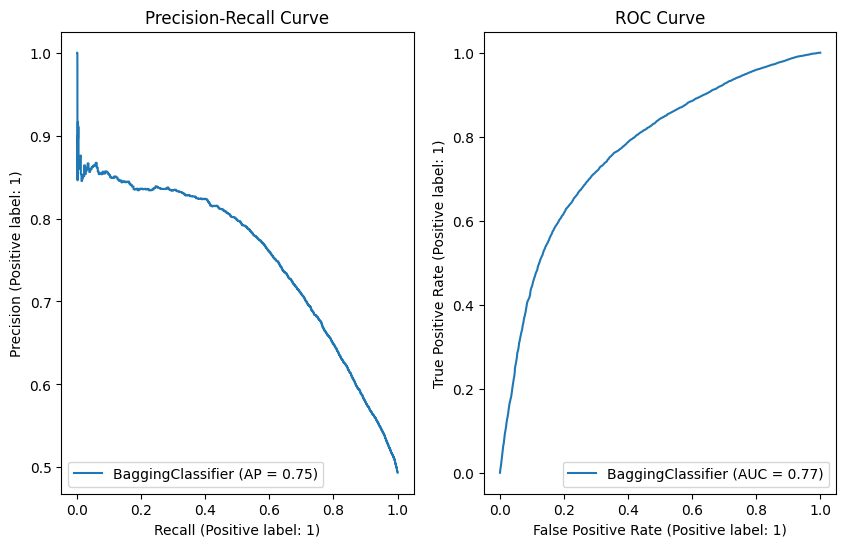

In [34]:
recall = recall_score(y_test, y_pred)
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(BC, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(BC, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()

### Gradient Bossting
#### Training and predicting the classifier

In [35]:
Gradient_Boost = GradientBoostingClassifier(learning_rate= 1, n_estimators= 10)
Gradient_Boost  = Gradient_Boost.fit(X_train, y_train)
y_pred = Gradient_Boost.predict(X_test)

#### Calculating the accuracy scores using confusion matrix

In [36]:
con_matrix = confusion_matrix(y_test, y_pred)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8012,2473
Actual 1,3056,7159


In [37]:
precision = precision_score(y_test, y_pred) *100
f1 = f1_score(y_test,y_pred) *100

print(f"{classification_report(y_test, y_pred)}")
print(f"Precision: {precision:.2f}%")
print(f"F1_score: {f1:.2f}%")

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     10485
           1       0.74      0.70      0.72     10215

    accuracy                           0.73     20700
   macro avg       0.73      0.73      0.73     20700
weighted avg       0.73      0.73      0.73     20700

Precision: 74.33%
F1_score: 72.14%


#### Plotting ROC curve and Precision-Recall curve

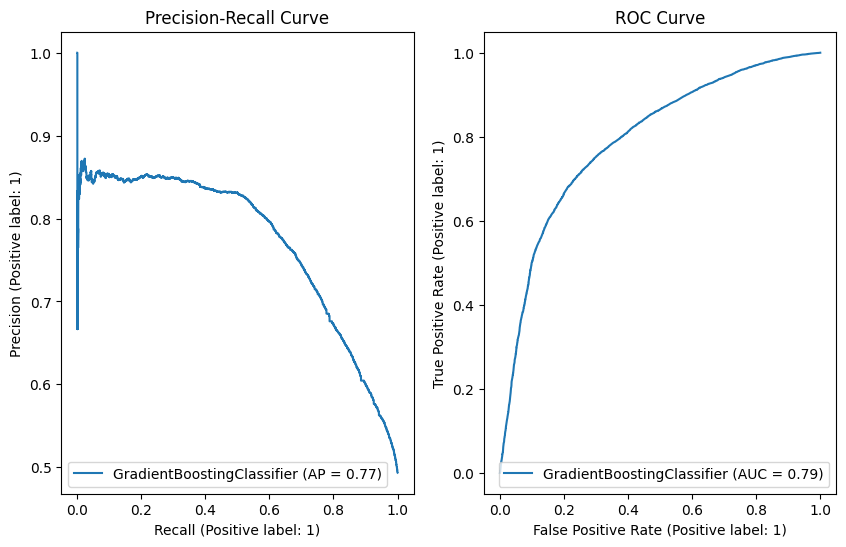

In [38]:
recall = recall_score(y_test, y_pred)
fpr , tpr, thresholds = roc_curve(y_test, y_pred)
fig,ax = plt.subplots(1,2, figsize = (10,6))
PrecisionRecallDisplay(precision= precision, recall= recall).from_estimator(Gradient_Boost, X_test, y_test, ax= ax[0])
RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc= auc(fpr,tpr)).from_estimator(Gradient_Boost, X_test, y_test, ax= ax[1])
ax[0].set_title("Precision-Recall Curve")
ax[1].set_title("ROC Curve")
plt.show()